In [34]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [38]:
training_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - Images from Dellaire Lab/input/set/training_set'
test_path = '/Users/pallavisingh/Library/CloudStorage/OneDrive-SharedLibraries-DalhousieUniversity/Priyadharshini Sridharan - Images from Dellaire Lab/input/set/test_set'

In [118]:
train_dataset = datasets.ImageFolder(training_path,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))
test_dataset = datasets.ImageFolder(test_path,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [104]:
img, label = train_dataset[1]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


In [105]:
print("Following classes are there : \n",train_dataset.classes)

Following classes are there : 
 ['arsenic', 'non_arsenic']


Label : arsenic


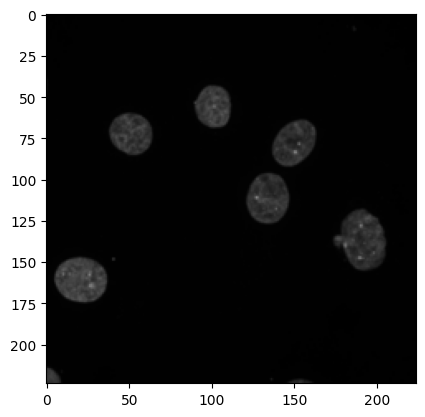

In [106]:
import matplotlib.pyplot as plt

def display_img(img,label):
    print(f"Label : {train_dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

#display the first image in the dataset
display_img(*train_dataset[2])

In [107]:
class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())
            self.conv2 = nn.Sequential(
                            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                            nn.BatchNorm2d(out_channels))
            self.downsample = downsample
            self.relu = nn.ReLU()
            self.out_channels = out_channels

        def forward(self, x):
            residual = x
            out = self.conv1(x)
            out = self.conv2(out)
            if self.downsample:
                residual = self.downsample(x)
            out += residual
            out = self.relu(out)
            return out

In [108]:
class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes = 2):
            super(ResNet, self).__init__()
            self.inplanes = 64
            self.conv1 = nn.Sequential(
                            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                            nn.BatchNorm2d(64),
                            nn.ReLU())
            self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
            self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
            self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
            self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
            self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
            self.avgpool = nn.AvgPool2d(7, stride=1)
            self.fc = nn.Linear(512, num_classes)

        def _make_layer(self, block, planes, blocks, stride=1):
            downsample = None
            if stride != 1 or self.inplanes != planes:

                downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                    nn.BatchNorm2d(planes),
                )
            layers = []
            layers.append(block(self.inplanes, planes, stride, downsample))
            self.inplanes = planes
            for i in range(1, blocks):
                layers.append(block(self.inplanes, planes))

            return nn.Sequential(*layers)

        def forward(self, x):
            x = self.conv1(x)
            x = self.maxpool(x)
            x = self.layer0(x)
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)

            x = self.avgpool(x)
            x = x.view(x.size(0), -1)
            x = self.fc(x)

            return x

In [109]:
num_classes = 2
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

#Train the model
total_step = len(train_loader)

In [110]:
import gc
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

print ('Epoch [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, loss.item()))



Epoch [20/20], Loss: 0.0041


In [119]:
#Validation
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    accuracy = correct / total
    print(f'Accuracy is {accuracy}')

Accuracy is 1.0


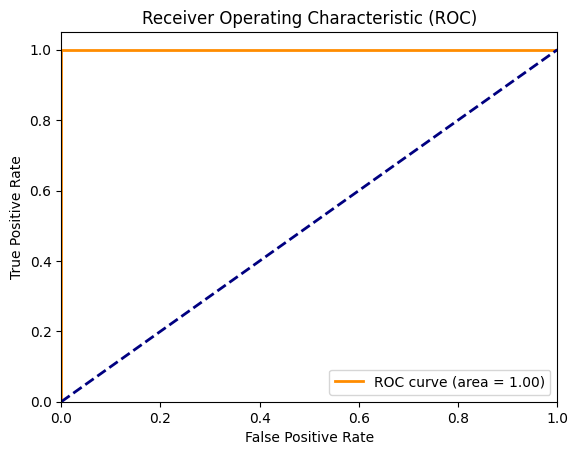

In [114]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Initialize containers for true labels and predicted probabilities
all_labels = []
all_probs = []

# Validation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Use softmax for multi-class, sigmoid for binary
        
        # Store labels and predicted probabilities
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

        del images, labels, outputs

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Assume binary classification for AUC computation
# Use the probabilities of the positive class (e.g., column index 1)
positive_probs = all_probs[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(all_labels, positive_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### Adding cropping, resizing, rotating images

In [60]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # Random vertical flip
    transforms.RandomRotation(30),           # Random rotation (up to 30 degrees)
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Use a larger crop size
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),  # Random color adjustments
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),  # Random blur for augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalization
])
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the original resolution
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalization
])

In [61]:
train_dataset_1 = datasets.ImageFolder(training_path,transform = train_transforms )
test_dataset_1 = datasets.ImageFolder(test_path,transform= test_transforms )

train_loader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True)
test_loader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False)

In [71]:
train_loader_1

In [66]:
num_classes = 2
num_epochs = 20
batch_size = 16
learning_rate = 0.01

model_1 = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

#Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

#Train the model
total_step = len(train_loader_1)

In [67]:
import gc
total_step = len(train_loader_1)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader_1):  
        #Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass
        outputs = model_1(images)
        loss = criterion(outputs, labels)

        #Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

print ('Epoch [{}/{}], Loss: {:.4f}' 
                .format(epoch+1, num_epochs, loss.item()))

Epoch [20/20], Loss: 0.9960


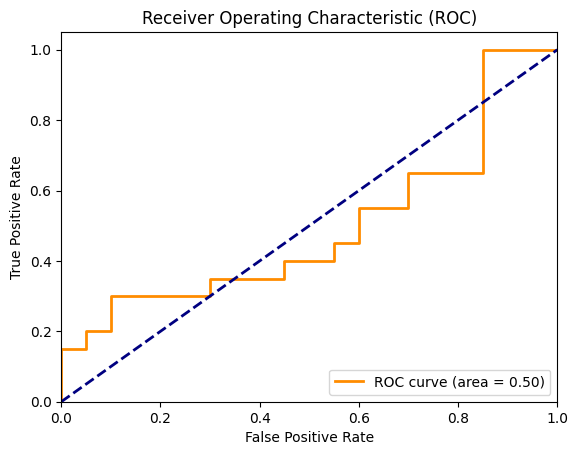

In [68]:
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Initialize containers for true labels and predicted probabilities
all_labels = []
all_probs = []

# Validation
with torch.no_grad():
    for images, labels in test_loader_1:
        images = images.to(device)
        labels = labels.to(device)

        # Get model outputs
        outputs = model_1(images)
        probabilities = torch.softmax(outputs, dim=1)  # Use softmax for multi-class, sigmoid for binary
        
        # Store labels and predicted probabilities
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

        del images, labels, outputs

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Assume binary classification for AUC computation
# Use the probabilities of the positive class (e.g., column index 1)
positive_probs = all_probs[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(all_labels, positive_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### Using Pretrained Model

In [72]:
from torchvision import models, datasets, transforms

In [95]:
# Load pretrained ResNet-50
model_pre = models.resnet18(pretrained=True)

# Modify the fully connected layer to match the number of classes in your dataset
num_classes = 2  # Number of classes
model_pre.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_classes)

# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pre = model_pre.to(device)


/Users/pallavisingh/anaconda3/envs/mlprojects/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/pallavisingh/anaconda3/envs/mlprojects/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [96]:
# Check the input features of the final fully connected layer (model.fc)
print(f"Original FC input features: {model_pre.fc.in_features}") 
print(model_pre)  # This will print out the full architecture and you can verify the number of features in the final layer


Original FC input features: 512
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [97]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pre.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [98]:
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model_pre.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model_pre(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")


Epoch [1/20], Loss: 0.2389
Epoch [2/20], Loss: 0.0124
Epoch [3/20], Loss: 0.0105
Epoch [4/20], Loss: 0.0215
Epoch [5/20], Loss: 0.0078
Epoch [6/20], Loss: 0.0002
Epoch [7/20], Loss: 0.0006
Epoch [8/20], Loss: 0.0036
Epoch [9/20], Loss: 0.0006
Epoch [10/20], Loss: 0.0124
Epoch [11/20], Loss: 0.0002
Epoch [12/20], Loss: 0.0019
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0001
Epoch [15/20], Loss: 0.0019
Epoch [16/20], Loss: 0.0001
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0006
Epoch [19/20], Loss: 0.0008
Epoch [20/20], Loss: 0.0002


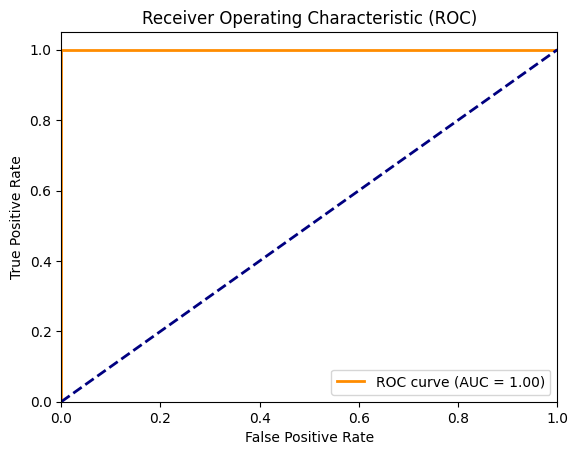

Test Accuracy: 100.00%


In [99]:
# Evaluation and AUC Curve
model_pre.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get predictions
        outputs = model_pre(images)
        probabilities = torch.softmax(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probabilities.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# For AUC: Use probabilities of the positive class (assuming binary classification)
if num_classes == 2:
    positive_probs = all_probs[:, 1]
    fpr, tpr, _ = roc_curve(all_labels, positive_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("AUC is applicable for binary classification. Extend for multi-class if needed.")

# Test Accuracy
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_pre(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# # Save the fine-tuned model
# torch.save(model.state_dict(), 'fine_tuned_resnet50.pth')

### Models Comparision

                 Model  Accuracy  Precision  Recall    F1-score       AUC
0             Baseline     100.0      100.0   100.0  100.000000  1.000000
1    Data Augmentation      50.0       50.0    50.0   48.849105  0.485625
2  Pretrained ResNet18     100.0      100.0   100.0  100.000000  1.000000


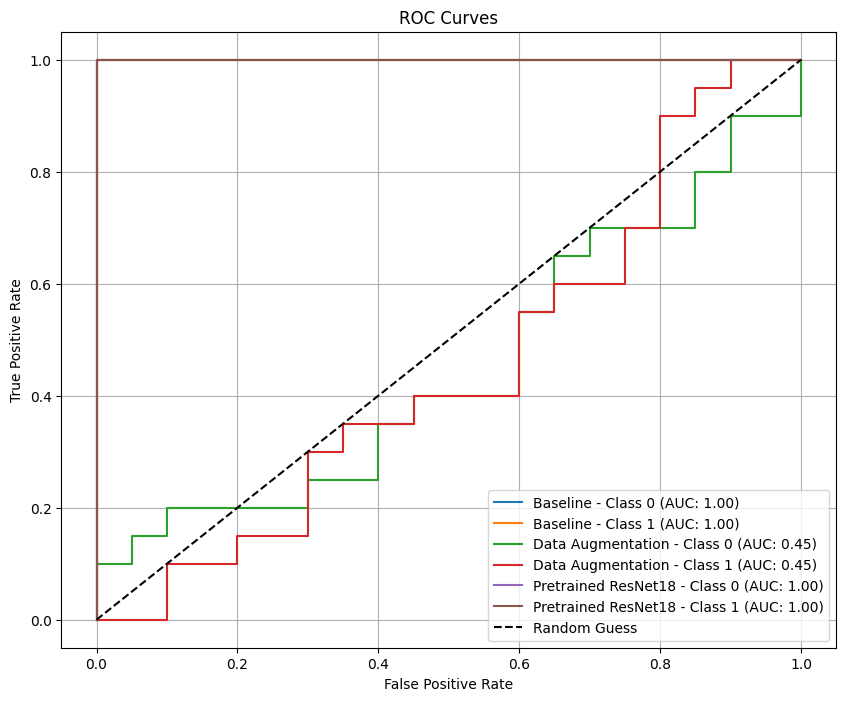

In [113]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Initialize your models
models = {"Baseline": model, 
          "Data Augmentation": model_1, 
          "Pretrained ResNet18": model_pre}

# Prepare to store metrics
metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": [], "AUC": []}
roc_data = {}

# Loop through each model and calculate metrics
for name, model in models.items():
    model.eval()
    y_true = []
    y_scores = []
#Validation

    # Iterate through test data
    with torch.no_grad():
        if name == "Baseline" or name == "Pretrained ResNet18":
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)  # Assuming multi-class classification
                y_scores.extend(probs.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
        else:
            for inputs, labels in test_loader_1:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)  # Assuming multi-class classification
                y_scores.extend(probs.cpu().numpy())
                y_true.extend(labels.cpu().numpy())
    
    y_scores = np.array(y_scores)
    y_pred = np.argmax(y_scores, axis=1)  # Convert probabilities to predictions
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average="weighted") * 100
    recall = recall_score(y_true, y_pred, average="weighted") * 100
    f1 = f1_score(y_true, y_pred, average="weighted") * 100

    # ROC and AUC calculation (for multi-class, one-vs-rest)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(np.unique(y_true))):  # Number of classes
        fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Store macro-average AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in fpr:
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(fpr)
    macro_auc = auc(all_fpr, mean_tpr)

    # Store results
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1-score"].append(f1)
    metrics["AUC"].append(macro_auc)

    # Store ROC data for plotting
    roc_data[name] = (fpr, tpr, roc_auc)

# Display metrics
import pandas as pd
df_metrics = pd.DataFrame(metrics)
print(df_metrics)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    for i in roc_auc:
        plt.plot(fpr[i], tpr[i], label=f'{name} - Class {i} (AUC: {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()


In [121]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Initialize your models
models = {
    "Baseline": model,
    "Data Augmentation": model_1,
    "Pretrained ResNet18": model_pre,
}

# Prepare to store metrics
metrics = {"Model": [], "Accuracy": [], "Precision": [], "Recall": [], "F1-score": []}

# Ensure test_loaders for each model are defined appropriately
test_loaders = {
    "Baseline": test_loader,
    "Data Augmentation": test_loader_1,  # Use test_loader_1 if applicable
    "Pretrained ResNet18": test_loader,
}

# Evaluate each model with consistent accuracy calculation
for name, model in models.items():
    model.eval()
    y_true, y_pred = [], []
    
    # Validation loop
    with torch.no_grad():
        for inputs, labels in test_loaders[name]:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Consistent with your earlier logic
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0) * 100
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0) * 100

    # Store results
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy)
    metrics["Precision"].append(precision)
    metrics["Recall"].append(recall)
    metrics["F1-score"].append(f1)

# Display metrics as a DataFrame
df_metrics = pd.DataFrame(metrics)
print("\nUpdated Model Metrics:\n", df_metrics)

# # Optional: Save metrics to a CSV file
# df_metrics.to_csv("model_metrics_comparison.csv", index=False)



Updated Model Metrics:
                  Model  Accuracy  Precision  Recall    F1-score
0             Baseline     100.0      100.0   100.0  100.000000
1    Data Augmentation      50.0       50.0    50.0   48.849105
2  Pretrained ResNet18     100.0      100.0   100.0  100.000000
